In [24]:
%pip install grad-cam

Note: you may need to restart the kernel to use updated packages.


In [25]:
# https://github.com/jacobgil/pytorch-grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torch.utils.data import Dataset, DataLoader
from dataset import FilenameLabelImageDataset
from torchvision import transforms

DATA_FOLDER = 'mask_output/images'

transform = transforms.ToTensor()

dataset = FilenameLabelImageDataset(DATA_FOLDER, transform=transform, exclude_classes={"Region"})
data = DataLoader(dataset, batch_size=1, shuffle=True)


ValueError: All ufuncs must have type `numpy.ufunc`. Received (<ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>)

In [ ]:
from model import CNN
import torch

model = CNN(num_classes=4)
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

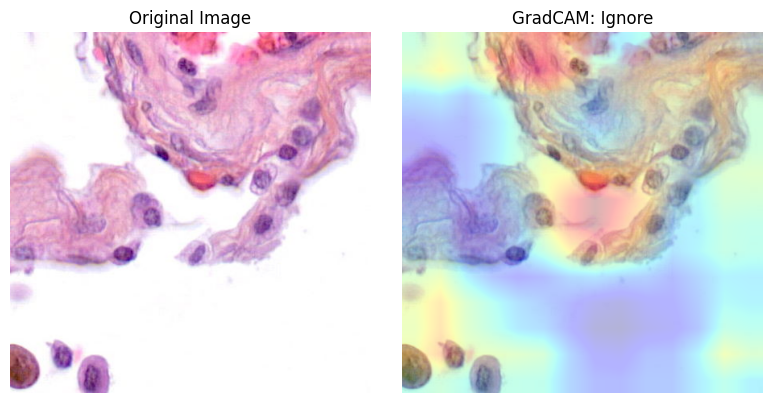

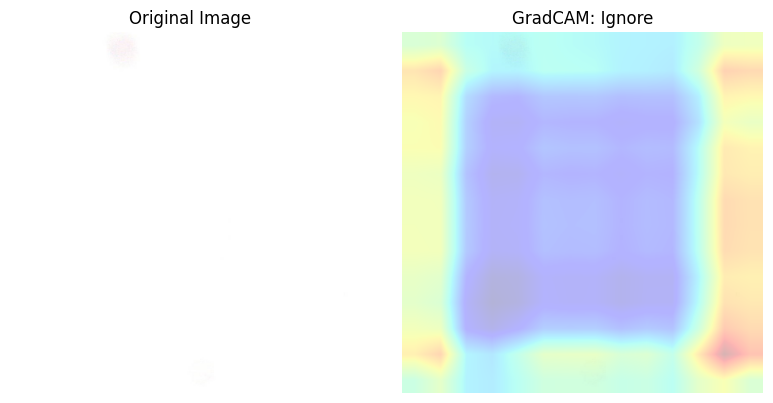

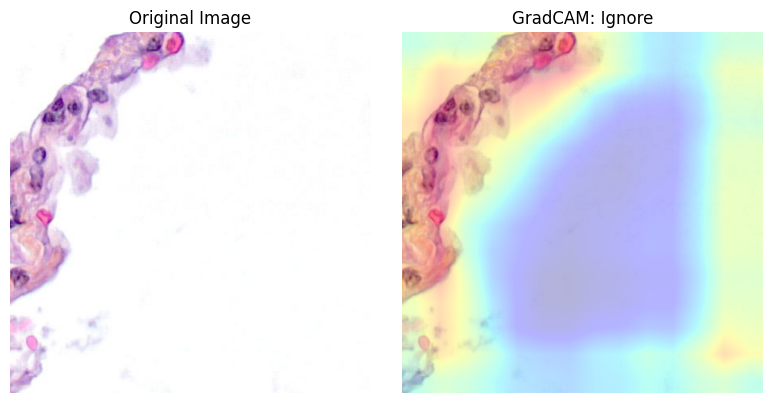

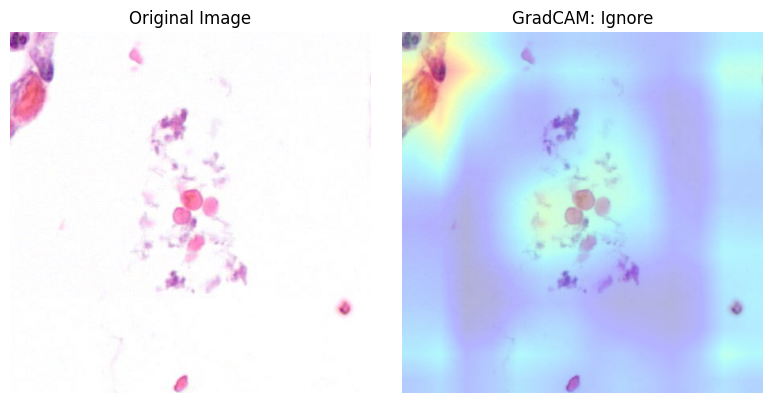

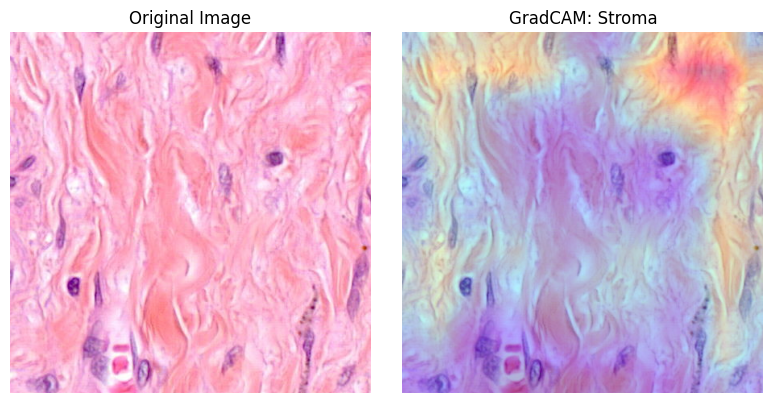

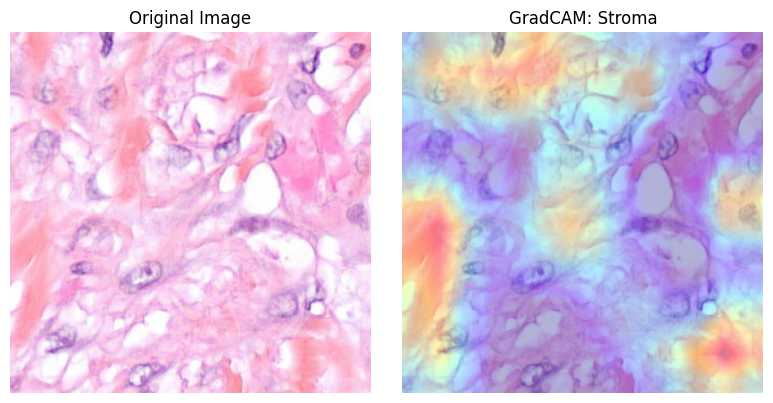

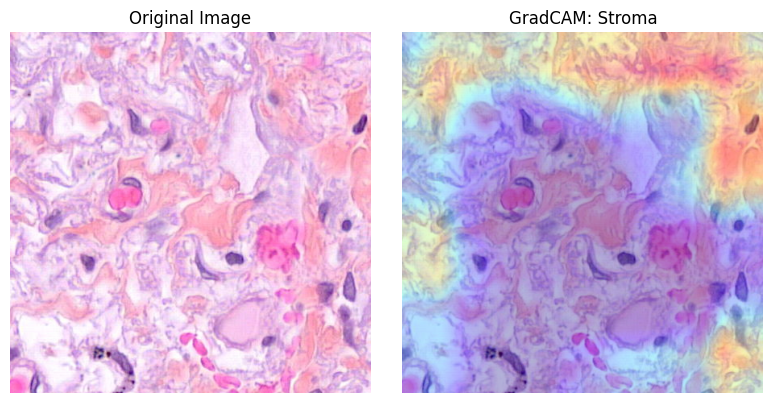

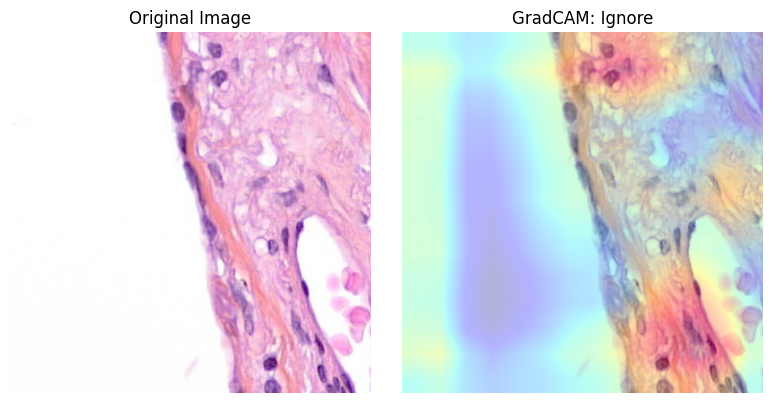

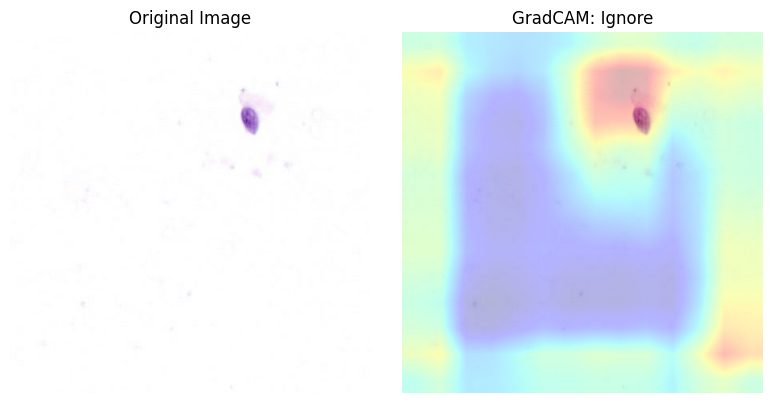

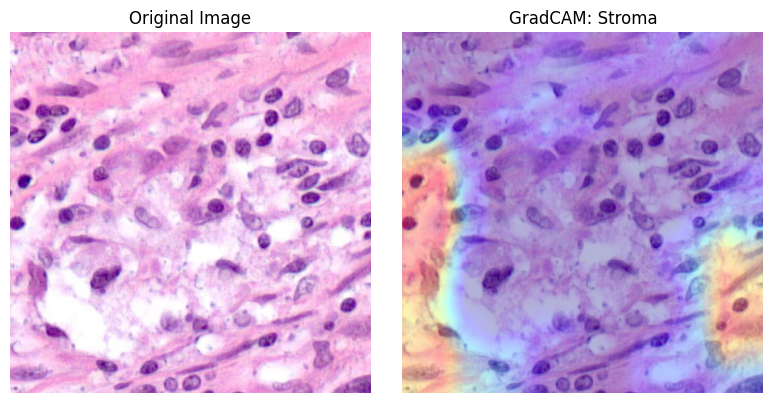

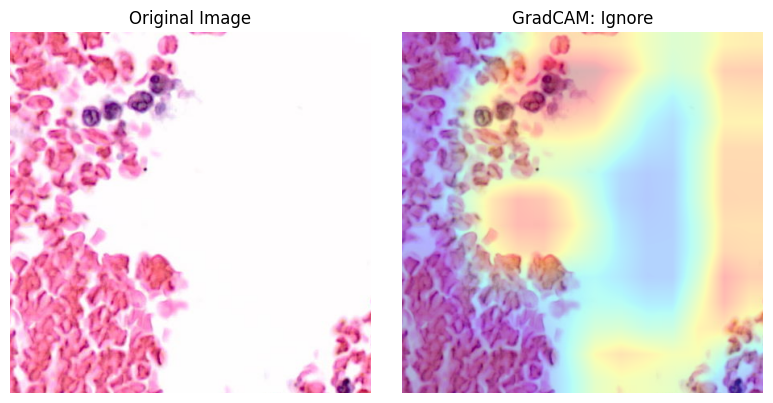

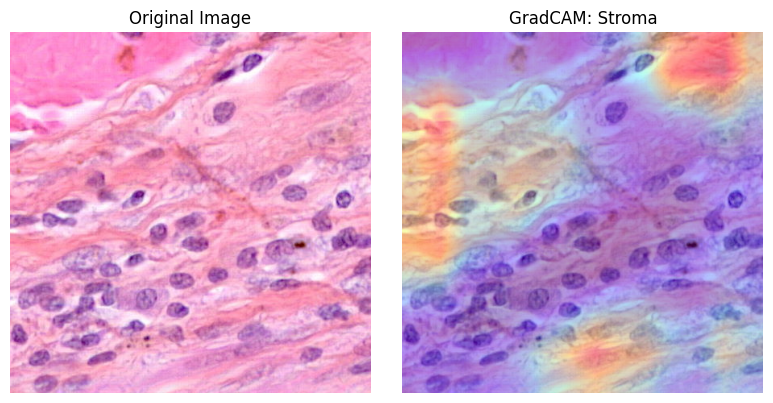

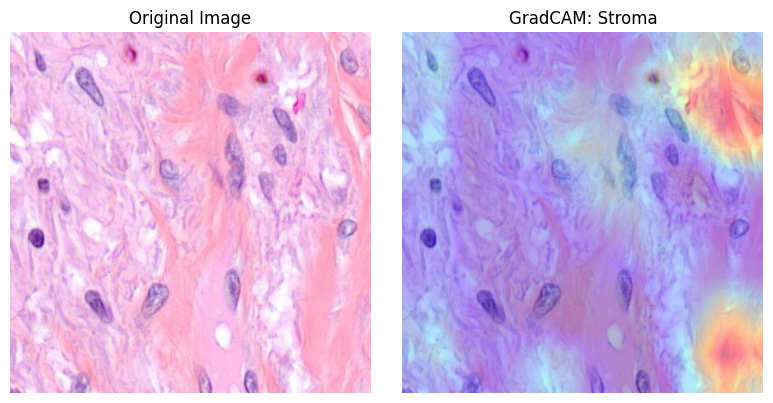

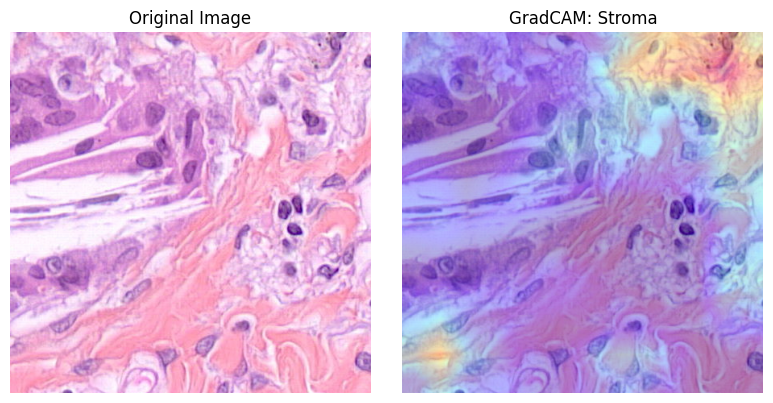

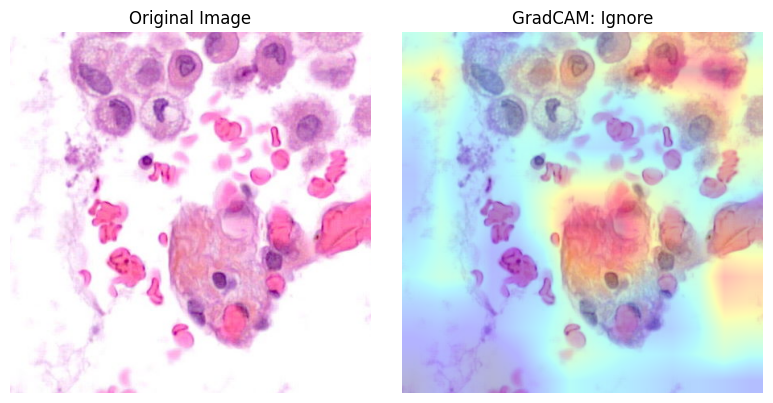

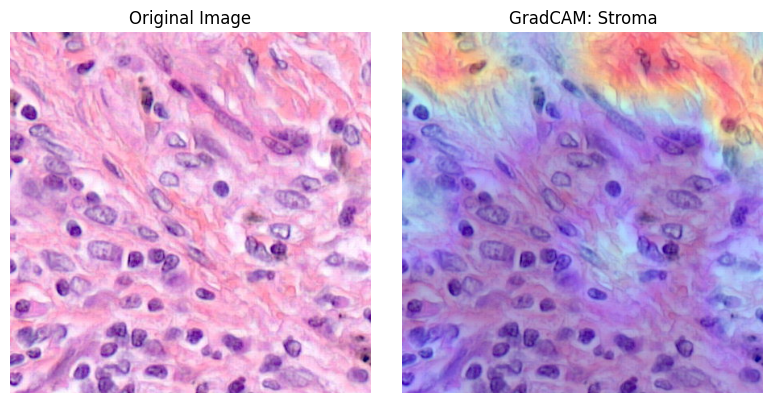

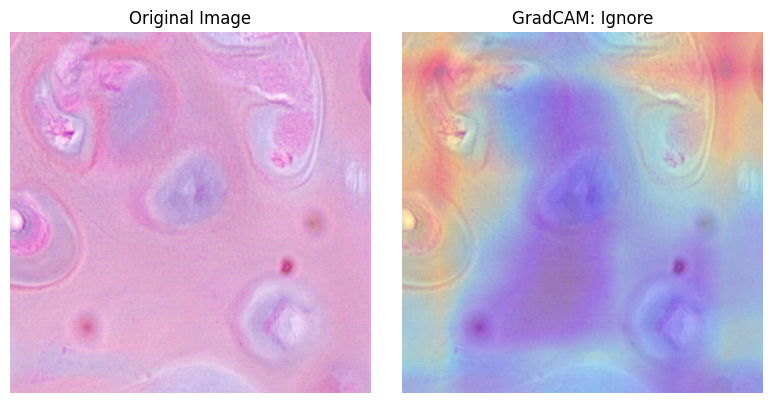

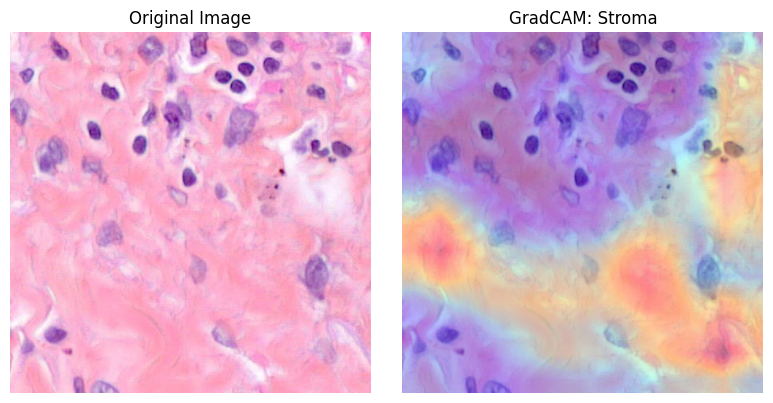

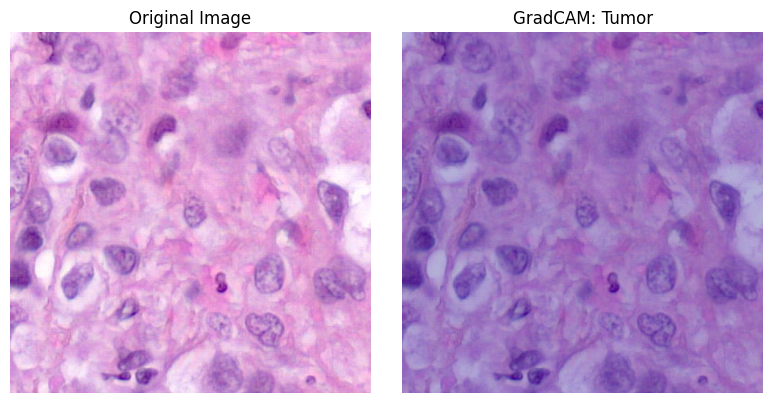

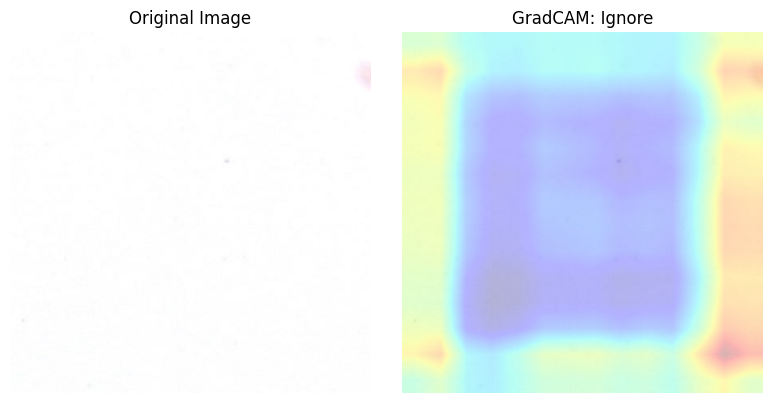

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

device = 'cuda' if torch.cuda.is_available() else 'cpu'

classes = {'Ignore': 0, 'Necrosis': 1, 'Stroma': 2, 'Tumor': 3}
class_id_to_name = {v: k for k, v in classes.items()}
target_layers = [model.model.layer4[-1]]
to_pil = ToPILImage()

model = model.to(device)
model.eval()

examples = {}
fig, axes = plt.subplots(1, len(classes), figsize=(12, 3))

for input_tensor, target_class in data:
    class_id = target_class.item()
    if class_id in examples:
        continue

    input_tensor = input_tensor.to(device)
    targets = [ClassifierOutputTarget(class_id)]

    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    rgb_img = to_pil(input_tensor[0].detach().cpu())
    ax = axes[class_id]
    ax.imshow(rgb_img)
    ax.imshow(grayscale_cam, cmap='jet', alpha=0.35)
    ax.set_title(f"GradCAM: {class_id_to_name[class_id]}")
    ax.axis('off')

    examples[class_id] = True
    if len(examples) == len(classes):
        break

plt.tight_layout()
plt.show()